In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn_pandas import DataFrameMapper, gen_features
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.base import clone

from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.feature_selection import chi2
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, make_scorer
from sklearn.decomposition import PCA
from sklearn.datasets import make_multilabel_classification
from sklearn.multiclass import OneVsRestClassifier


plt.style.use('ggplot')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: ignored

# Data

In [ ]:
df = pd.read_csv("drive/MyDrive/training/HW/data/dataset_57_hypothyroid.csv", sep=",",  na_values = "?")
df


,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.30,t,2.5,t,125.0,t,1.14,t,109.0,f,NaN,SVHC,negative
1,23.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,4.10,t,2.0,t,102.0,f,NaN,f,NaN,f,NaN,other,negative
2,46.0,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.98,f,NaN,t,109.0,t,0.91,t,120.0,f,NaN,other,negative
3,70.0,F,t,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.16,t,1.9,t,175.0,f,NaN,f,NaN,f,NaN,other,negative
4,70.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.72,t,1.2,t,61.0,t,0.87,t,70.0,f,NaN,SVI,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,30.0,F,f,f,f,f,f,f,f,f,f,f,f,t,f,f,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,other,negative
3768,68.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.00,t,2.1,t,124.0,t,1.08,t,114.0,f,NaN,SVI,negative
3769,74.0,F,f,f,f,f,f,f,f,f,t,f,f,f,f,f,t,5.10,t,1.8,t,112.0,t,1.07,t,105.0,f,NaN,other,negative
3770,72.0,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.70,t,2.0,t,82.0,t,0.94,t,87.0,f,NaN,SVI,negative


* It seems, that features ending with '_measured' are indicators for missing values in according columns.
* A lot of columns have categorical types. Moreover, almost all of them are binary.
* It seems, that column referral_source doesn't give any information about the patient, and probably in real task it would not be required.

In [ ]:
df.drop('referral_source', axis=1, inplace=True)

# EDA

## Missing Values

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        3771 non-null   float64
 1   sex                        3622 non-null   object 
 2   on_thyroxine               3772 non-null   object 
 3   query_on_thyroxine         3772 non-null   object 
 4   on_antithyroid_medication  3772 non-null   object 
 5   sick                       3772 non-null   object 
 6   pregnant                   3772 non-null   object 
 7   thyroid_surgery            3772 non-null   object 
 8   I131_treatment             3772 non-null   object 
 9   query_hypothyroid          3772 non-null   object 
 10  query_hyperthyroid         3772 non-null   object 
 11  lithium                    3772 non-null   object 
 12  goitre                     3772 non-null   object 
 13  tumor                      3772 non-null   objec

In [ ]:
for col in df.columns:
  if len(df[col].unique()) == 1 :
    print(col)

TBG_measured
TBG


TBG and TBG_measured do not contain any information and must be dropped.

In [ ]:
df.drop(["TBG", "TBG_measured"], axis=1, inplace=True)

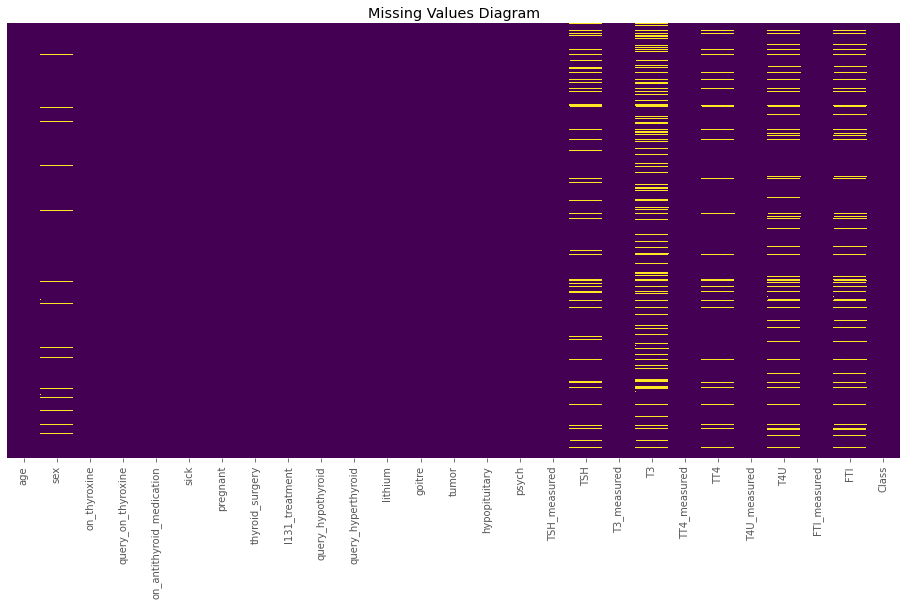

In [ ]:
plt.figure(figsize=(16, 8))
plt.title('Missing Values Diagram')
ax = sns.heatmap((df.isna()), cbar=False,yticklabels=False,cmap = 'viridis');

for item in ax.get_xticklabels():
    item.set_rotation(90)

In [ ]:
((df.isna())).mean().sort_values(ascending=False)

T3                           0.203871
T4U                          0.102598
FTI                          0.102068
TSH                          0.097826
TT4                          0.061241
sex                          0.039767
age                          0.000265
query_hyperthyroid           0.000000
on_thyroxine                 0.000000
query_on_thyroxine           0.000000
on_antithyroid_medication    0.000000
sick                         0.000000
pregnant                     0.000000
thyroid_surgery              0.000000
I131_treatment               0.000000
query_hypothyroid            0.000000
Class                        0.000000
lithium                      0.000000
goitre                       0.000000
hypopituitary                0.000000
psych                        0.000000
TSH_measured                 0.000000
T3_measured                  0.000000
TT4_measured                 0.000000
T4U_measured                 0.000000
FTI_measured                 0.000000
tumor       

## General Insights

In [ ]:
CATEGORICAL = df.select_dtypes(include=['object']).columns.tolist()
CATEGORICAL.remove('Class')
NUMERICAL = df.select_dtypes(exclude=['object']).columns.tolist()
TARGET = 'Class'

In [ ]:
df.Class.value_counts()

negative                   3481
compensated_hypothyroid     194
primary_hypothyroid          95
secondary_hypothyroid         2
Name: Class, dtype: int64

* It seems, that the dataset is unbalanced. Also, target contains too little samples of secondary_hypothyroid, so we can drop them.
* Also, names of categories in traget are too long. We will change it.

In [ ]:
df = df[~(df.Class == 'secondary_hypothyroid')]

In [ ]:
mapper = {
    'negative': 'neg',
    'compensated_hypothyroid': 'ch',
    'primary_hypothyroid': 'ph',
}
df.Class = df.Class.map(mapper)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
df.Class.value_counts()

neg    3481
ch      194
ph       95
Name: Class, dtype: int64

In [ ]:
df.describe()

,age,TSH,T3,TT4,T4U,FTI
count,3769.000000,3401.000000,3001.000000,3539.000000,3384.000000,3386.000000
mean,51.740249,5.088400,2.013609,108.360780,0.995031,110.486326
std,20.089309,24.528526,0.827529,35.570254,0.195478,33.080345
min,1.000000,0.005000,0.050000,2.000000,0.250000,2.000000
25%,36.000000,0.500000,1.600000,88.000000,0.880000,93.000000
50%,54.000000,1.400000,2.000000,103.000000,0.980000,107.000000
75%,67.000000,2.700000,2.400000,124.000000,1.080000,124.000000
max,455.000000,530.000000,10.600000,430.000000,2.320000,395.000000


We can try to process the outlier in age, because it looks like a misspell.

In [ ]:
df.loc[df.age == 455, 'age'] = 45

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


## Continious values relationship with target

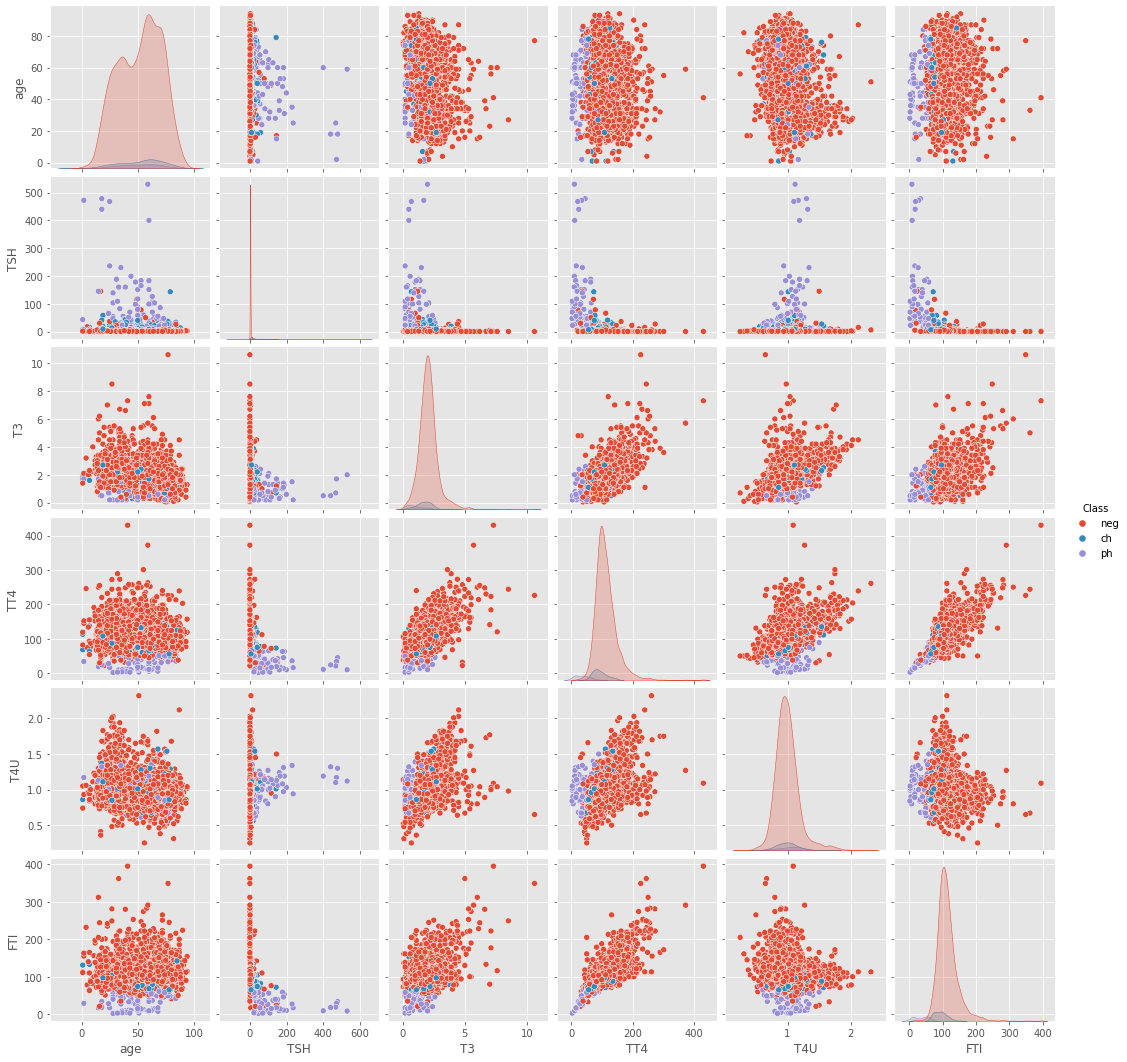

In [ ]:
ax = sns.pairplot(df, hue='Class');

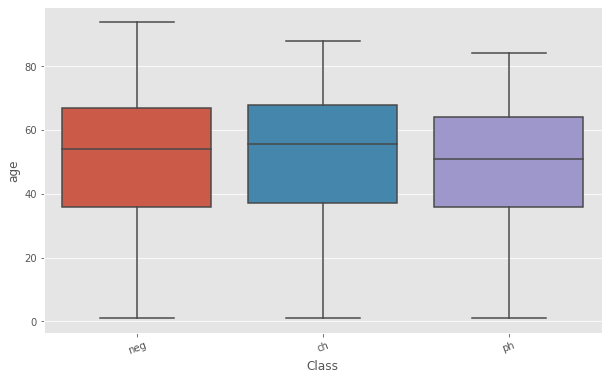

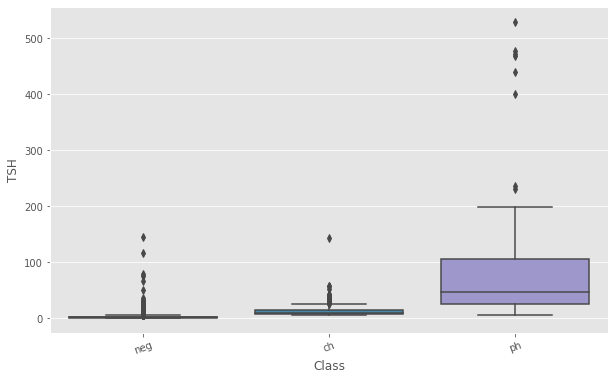

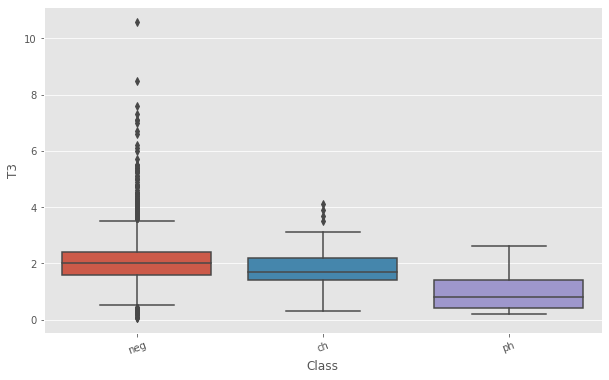

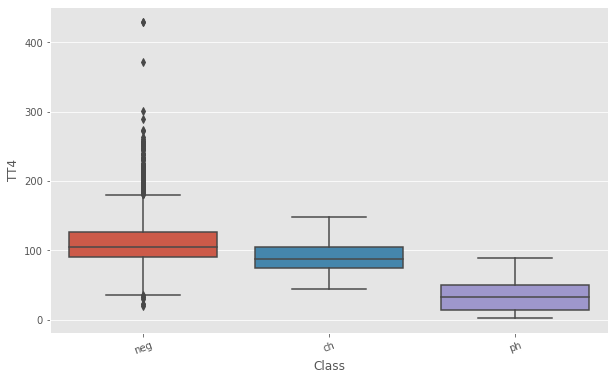

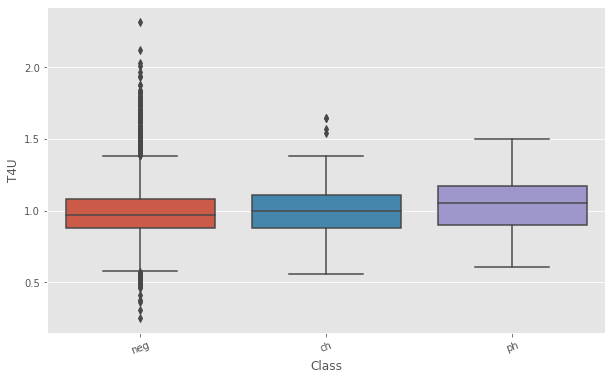

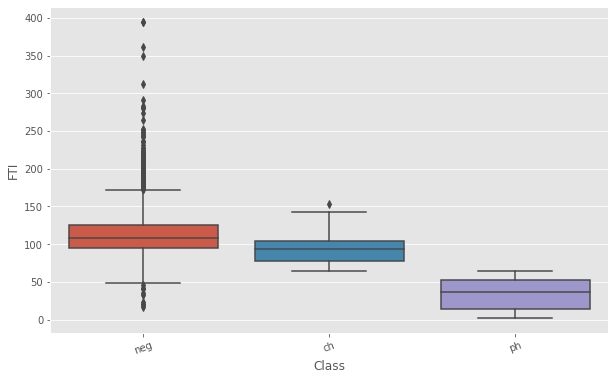

In [ ]:
for col in NUMERICAL:
  plt.figure(figsize=(10, 6))
  ax = sns.boxplot(y=col ,x=TARGET, data=df)
  for item in ax.get_xticklabels():
      item.set_rotation(20)
  plt.show()

Some insights for pairplot and boxplots:
* It seem, that there is no any noticeable relationship between target and age.
* TSH is higher for smaples with primary_hypothyroid.
* TT4 and FTI probably show some relationship with target.
* TSH is near to zero for many samples.

## Categorical values relationship with target

Now we will try to find some patterns for categorical features. Firstly we will define the proportion of classes in total. Secondly we will investigate how grouping influences the proportion of classes. Also, we will try to find some strange features.

In [ ]:
print(df.groupby('Class').Class.agg('count') / df.shape[0])
for i, feature in enumerate(CATEGORICAL):
    d = df.groupby([feature, 'Class']).Class.agg('count').unstack()
    
    d['total']= d.sum(axis=1)
    d['neg'] = d['neg'] / d['total']
    d['ch'] = d['ch'] / d['total']
    d['ph'] = d['ph'] / d['total']
    
    display(d)
    print('\n')


Class
ch     0.051459
neg    0.923342
ph     0.025199
Name: Class, dtype: float64


Class,ch,neg,ph,total
sex,,,,
F,0.058491,0.913675,0.027834,2479
M,0.036810,0.943909,0.019281,1141


Class,ch,neg,ph,total
on_thyroxine,,,,
f,0.058681,0.915306,0.026013,3306.0
t,NaN,0.980603,0.019397,464.0


Class,ch,neg,ph,total
query_on_thyroxine,,,,
f,0.051344,0.923118,0.025538,3720.0
t,0.060000,0.940000,NaN,50.0


Class,ch,neg,ph,total
on_antithyroid_medication,,,,
f,0.051784,0.922726,0.02549,3727.0
t,0.023256,0.976744,NaN,43.0


Class,ch,neg,ph,total
sick,,,,
f,0.050511,0.923268,0.026221,3623.0
t,0.074830,0.925170,NaN,147.0


Class,ch,neg,ph,total
pregnant,,,,
f,0.052193,0.922249,0.025558,3717.0
t,NaN,1.000000,NaN,53.0


Class,ch,neg,ph,total
thyroid_surgery,,,,
f,0.052193,0.922787,0.025020,3717.0
t,NaN,0.962264,0.037736,53.0


Class,ch,neg,ph,total
I131_treatment,,,,
f,0.051469,0.923471,0.025061,3711
t,0.050847,0.915254,0.033898,59


Class,ch,neg,ph,total
query_hypothyroid,,,,
f,0.047215,0.929036,0.023749,3537
t,0.115880,0.836910,0.047210,233


Class,ch,neg,ph,total
query_hyperthyroid,,,,
f,0.051514,0.922446,0.026040,3533
t,0.050633,0.936709,0.012658,237


Class,ch,neg,ph,total
lithium,,,,
f,0.051439,0.923241,0.02532,3752.0
t,0.055556,0.944444,NaN,18.0


Class,ch,neg,ph,total
goitre,,,,
f,0.051927,0.922645,0.025428,3736.0
t,NaN,1.000000,NaN,34.0


Class,ch,neg,ph,total
tumor,,,,
f,0.05117,0.923517,0.025313,3674
t,0.06250,0.916667,0.020833,96


Class,ch,neg,ph,total
hypopituitary,,,,
f,0.051473,0.923322,0.025206,3769.0
t,NaN,1.000000,NaN,1.0


Class,ch,neg,ph,total
psych,,,,
f,0.051868,0.921640,0.026492,3586.0
t,0.043478,0.956522,NaN,184.0


Class,ch,neg,ph,total
TSH_measured,,,,
f,NaN,1.000000,NaN,369.0
t,0.057042,0.915025,0.027933,3401.0


Class,ch,neg,ph,total
T3_measured,,,,
f,0.048114,0.940182,0.011704,769
t,0.052316,0.919027,0.028657,3001


Class,ch,neg,ph,total
TT4_measured,,,,
f,0.008658,0.978355,0.012987,231
t,0.054253,0.919751,0.025996,3539


Class,ch,neg,ph,total
T4U_measured,,,,
f,0.044041,0.937824,0.018135,386
t,0.052305,0.921690,0.026005,3384


Class,ch,neg,ph,total
FTI_measured,,,,
f,0.044271,0.937500,0.018229,384
t,0.052274,0.921737,0.025989,3386


* hypopituitary contains only 1 't'. This column cannot be informative. We will drop it.
* We can see, that proportions for some features differ from proportion in total, but not very significant. We will not drop any columns right now (despite hypopituitary). So, to define important features, we will use FeatureSelection stage in pipeline to drop unnecessary columns.

In [ ]:
df.drop('hypopituitary', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# Data Preparation

## Features preparation

In [ ]:
CATEGORICAL = ['sex','on_thyroxine','query_on_thyroxine','on_antithyroid_medication','sick','pregnant','thyroid_surgery',
               'I131_treatment','query_hypothyroid','query_hyperthyroid','lithium','goitre','tumor',
               'psych','TSH_measured','T3_measured','TT4_measured','T4U_measured','FTI_measured']
CATEGORICAL = ['sex','on_thyroxine','query_on_thyroxine','on_antithyroid_medication','sick','pregnant','thyroid_surgery',
               'I131_treatment','query_hypothyroid','query_hyperthyroid','lithium','goitre','tumor',
               'psych','TSH_measured','T3_measured','TT4_measured','T4U_measured','FTI_measured']

NUMERICAL = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']
NUMERICAL = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']
TARGET = 'Class'
BINARY = ['sex'] + [col for col in CATEGORICAL if len(df[col].unique()) == 2]
BINARY

['sex',
 'on_thyroxine',
 'query_on_thyroxine',
 'on_antithyroid_medication',
 'sick',
 'pregnant',
 'thyroid_surgery',
 'I131_treatment',
 'query_hypothyroid',
 'query_hyperthyroid',
 'lithium',
 'goitre',
 'tumor',
 'psych',
 'TSH_measured',
 'T3_measured',
 'TT4_measured',
 'T4U_measured',
 'FTI_measured']

Note\* Ordinal encoder helps to encode binary features to 0 and 1.

In [ ]:
numerical_def = gen_features(
    columns=[[c] for c in NUMERICAL],
    classes=[
        {'class': SimpleImputer, 'strategy': 'median'},
        {'class': PowerTransformer}
    ]
)
# SimpleImputer, 'strategy': 'median'

bin_def = gen_features(
    columns=[[c] for c in BINARY],
    classes=[
        {'class': SimpleImputer, 'strategy': 'most_frequent'},
        {'class': OrdinalEncoder}
    ]
)

In [ ]:
features = numerical_def + bin_def
mapper = DataFrameMapper(features)
len(features)

25

## Target encoding

In [ ]:
df.Class.unique()

array(['neg', 'ch', 'ph'], dtype=object)

In [ ]:
target_names = ['neg', 'ch', 'ph']
mapper_y = {
    'neg': 0,
    'ch': 1, 
    'ph': 2,
}
y = df.Class.map(mapper_y)
y

0       0
1       0
2       0
3       0
4       0
       ..
3767    0
3768    0
3769    0
3770    0
3771    0
Name: Class, Length: 3770, dtype: int64

## Train/Test split

In [ ]:
#X = pd.DataFrame(mapper.fit_transform(df), columns=mapper.transformed_names_)
X_train, X_test, y_train, y_test = train_test_split(df.drop('Class', axis=1), y, test_size=0.3, shuffle=True, random_state=42)
X_train.shape[0], X_test.shape[0]

(2639, 1131)

# Baseline model

Firstly we need to build first simple model and get basic results.

In [ ]:
f1 = make_scorer(f1_score , average='macro')

In [ ]:
def conf_matrix(y_true, y_pred, target_names):
  conf = confusion_matrix(y_true, y_pred)
  print(conf)
  sns.heatmap(conf,
              annot=conf/np.sum(conf, axis=1)[:, np.newaxis], #normalized by true class sizes
              yticklabels=target_names,
              xticklabels=target_names,
              cmap='bwr');
  plt.title('Logistic regression confusion matrix');
  plt.xlabel('Predicted label');
  plt.ylabel('True label');

We will use next metrics to asses the results: f1 score, precision, recall. Also, we will analyse confusion matrix. The main metric is f1(macro).

In [ ]:
tr_X_train, tr_X_val, tr_y_train, tr_y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=True, random_state=42)

pipeline = Pipeline([
    ('mapper', mapper),
    ('estimator', LogisticRegression(max_iter=10000))
])

pipeline.fit(tr_X_train, tr_y_train)
y_pred = pipeline.predict(tr_X_val)
y_pred_train = pipeline.predict(tr_X_train
                                )
print(classification_report(tr_y_val, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       739
           1       0.77      0.79      0.78        34
           2       0.88      0.74      0.80        19

    accuracy                           0.98       792
   macro avg       0.88      0.84      0.86       792
weighted avg       0.98      0.98      0.98       792



[[733   4   2]
 [  7  27   0]
 [  1   4  14]]


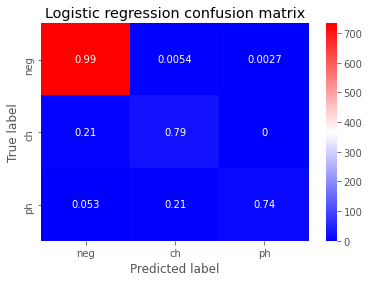

In [ ]:
conf_matrix(tr_y_val, y_pred, target_names)

In [ ]:
print("f1 on train:", f1_score(tr_y_train, y_pred_train, average='macro'))
print("f1 on test: ", f1_score(tr_y_val, y_pred, average='macro'))

f1 on train: 0.925231753492623
f1 on test:  0.8577164120642381


We can see, that our model well predicts negative class. It is connected to that the data is imbalanced. Analysing confusion matrix and classification report for other 2 classes, we can see much worse results.

There are some strategies to improve predicting ability of the model:
* **Oversampling**. This strategy can help to balance data, but it can lead to overfitting, because model will learn on repeating samples.
* **SMOTE**. This strategy can generate new synthetic samples. 
* **RandomForestClassification**. Also, we can try to use RFC. This algorithm works well with imbalanced data and categorical data. In our case, there are many categorical features in the dataset. SO, we can try to use this classification algorithm to improve predicting ability.

# Dealing with imbalanced data

## Oversampling

In [ ]:
cv = KFold(n_splits=3, shuffle=True, random_state=42)

pipeline = Pipeline([
    ('mapper', DataFrameMapper(features)),
    ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False, random_state=42, max_iter=10000))),
    ('estimator', LogisticRegression(max_iter=10000))
])

grid = {
    'estimator__C': np.linspace(0, 1, 10),
    'feature_selection__estimator__C': np.linspace(0, 0.15, 5),
}

gs = GridSearchCV(pipeline, grid, 
                  n_jobs=-1, 
                  scoring=f1,
                  cv=cv,
                  verbose=10)

In [ ]:
from sklearn.utils import resample

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
neg = X[X.Class==0]
ch = X[X.Class==1]
ph = X[X.Class==2]

# upsample minority
ch = resample(ch,
                replace=True,
                n_samples=len(neg),
                random_state=42) 

ph = resample(ph,
                replace=True,
                n_samples=len(neg),
                random_state=42)

# combine majority and upsampled minority
upsampled_train = pd.concat([neg, ch, ph], join='inner')

# check new class counts
upsampled_train.Class.value_counts()

2    2436
1    2436
0    2436
Name: Class, dtype: int64

In [ ]:
gs.fit(upsampled_train.drop('Class', axis=1), upsampled_train.Class)
y_pred = gs.predict(X_test)
y_pred_train = gs.predict(upsampled_train.drop('Class', axis=1))
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   54.3s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  2

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1045
           1       0.64      0.98      0.78        57
           2       0.82      0.93      0.87        29

    accuracy                           0.97      1131
   macro avg       0.82      0.96      0.88      1131
weighted avg       0.98      0.97      0.97      1131



In [ ]:
gs.best_params_

{'estimator__C': 0.6666666666666666, 'feature_selection__estimator__C': 0.0375}

In [ ]:
print("f1 on train:", f1_score(upsampled_train.Class, y_pred_train, average='macro'))
print("f1 on test: ", f1_score(y_test, y_pred, average='macro'))

f1 on train: 0.9768016508706691
f1 on test:  0.8774028515775724


[[1011   29    5]
 [   0   56    1]
 [   0    2   27]]


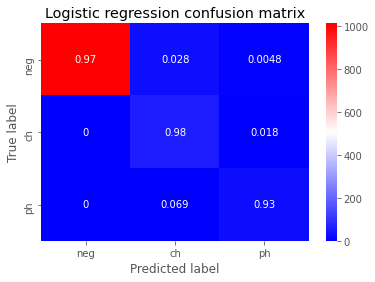

In [ ]:
conf_matrix(y_test, y_pred, target_names)

We can see, that our model significantly overfitted with oversamled train part. It still can well predict negative class, but has some troubles with others (precision for ch and ph). Let's try to use Logistic Regression with regularization.

## Smote

In [ ]:
from imblearn.over_sampling import SMOTENC
 
cat_ind = [i for i, v in enumerate(X_train.columns) if v in CATEGORICAL]
smotenc = SMOTENC(categorical_features = cat_ind)
 
simp = SimpleImputer(strategy='most_frequent')
X_train[CATEGORICAL] = simp.fit_transform(X_train[CATEGORICAL])
X_test[CATEGORICAL] = simp.transform(X_test[CATEGORICAL])
 
simp = SimpleImputer(strategy='median')
X_train[NUMERICAL] = simp.fit_transform(X_train[NUMERICAL])
X_test[NUMERICAL] = simp.transform(X_test[NUMERICAL])
 
oversampled_features, oversampled_target = smotenc.fit_sample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_train_smote = pd.DataFrame(oversampled_features, columns=X_train.columns)
y_train_smote = pd.DataFrame(oversampled_target, columns=['Class'])

In [ ]:
cv = KFold(n_splits=3, shuffle=True, random_state=42)

pipeline = Pipeline([
    ('mapper', DataFrameMapper(features)),
    ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False, random_state=42, max_iter=10000))),
    ('estimator', LogisticRegression(max_iter=10000))
])

grid = {
    'estimator__C': np.linspace(0.5, 1, 5),
    'feature_selection__estimator__C': np.linspace(0, 0.15, 10),
}

gs = GridSearchCV(pipeline, grid, 
                  n_jobs=-1, 
                  scoring=f1,
                  cv=cv,
                  verbose=10)

In [ ]:
gs.fit(X_train_smote, y_train_smote)
y_pred = gs.predict(X_test)
y_pred_train = gs.predict(X_train_smote)
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  1

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1045
           1       0.65      0.93      0.77        57
           2       0.74      0.86      0.79        29

    accuracy                           0.97      1131
   macro avg       0.80      0.92      0.85      1131
weighted avg       0.97      0.97      0.97      1131



In [ ]:
gs.best_params_

{'estimator__C': 0.5, 'feature_selection__estimator__C': 0.08333333333333333}

In [ ]:
print("f1 on train:", f1_score(y_train_smote, y_pred_train, average='macro'))
print("f1 on test: ", f1_score(y_test, y_pred, average='macro'))

f1 on train: 0.9656808305894615
f1 on test:  0.8489084978547673


[[1015   24    6]
 [   1   53    3]
 [   0    4   25]]


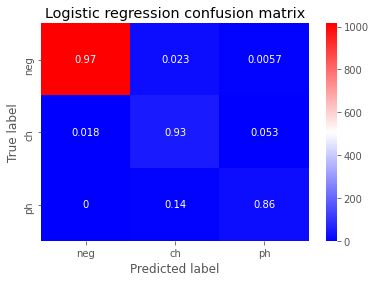

In [ ]:
conf_matrix(y_test, y_pred, target_names)

It seems, that SMOTE has shown worse results, than oversampling. Let's try to check models on original data. 

Overall, strategy of generating samples didn't show any serious improving. Both methods revealed significant overfitting.

# Cross Validation without generating samples.

## Logistic Regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Class', axis=1), y, test_size=0.3, shuffle=True, random_state=42)

In [ ]:
cv = KFold(n_splits=3, shuffle=True, random_state=42)

pipeline = Pipeline([
    ('mapper', DataFrameMapper(features)),
    ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False, random_state=42, max_iter=10000))),
    ('estimator', LogisticRegression(max_iter=10000))
])

grid = {
    'estimator__C': np.linspace(0, 50, 10),
    'feature_selection__estimator__C': np.linspace(0, 0.2, 10),
}

gs = GridSearchCV(pipeline, grid, 
                  n_jobs=-1, 
                  scoring=f1,
                  cv=cv,
                  verbose=10)

In [ ]:
gs.fit(X_train, y_train)
y_pred = gs.predict(X_test)
y_pred_train = gs.predict(X_train)
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1045
           1       0.91      0.91      0.91        57
           2       0.89      0.83      0.86        29

    accuracy                           0.99      1131
   macro avg       0.93      0.91      0.92      1131
weighted avg       0.99      0.99      0.99      1131



In [ ]:
best_SVC = gs.best_params_['feature_selection__estimator__C']
gs.best_params_

{'estimator__C': 11.11111111111111,
 'feature_selection__estimator__C': 0.17777777777777778}

In [ ]:

print("f1 on train:", f1_score(y_train, y_pred_train, average='macro'))
print("f1 on test: ", f1_score(y_test, y_pred, average='macro'))

f1 on train: 0.9351803212774784
f1 on test:  0.9215478147248298


[[1041    1    3]
 [   5   52    0]
 [   1    4   24]]


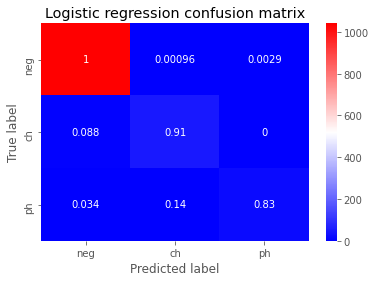

In [ ]:
conf_matrix(y_test, y_pred, target_names)

It seems, that results without generating new samples are much better. There is no significant overfitting and score on test is better.

## KNN

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

pipeline = Pipeline([
    ('mapper', DataFrameMapper(features)),
    ('feature_selection', SelectFromModel(LinearSVC( penalty="l1", dual=False, random_state=42, max_iter=10000))),
    ('estimator', KNeighborsClassifier())
])

grid = {
    'estimator__n_neighbors': [2, 5, 10, 15, 20, 25, 30],
    'estimator__p': [1, 2],
    'estimator__weights': ['uniform'],
    'feature_selection__estimator__C': np.linspace(0, 0.5, 10)
}

gs = GridSearchCV(pipeline, grid, 
                  n_jobs=-1, 
                  scoring=f1,
                  cv=cv,
                  verbose=5)

In [ ]:
gs.fit(X_train, y_train)
y_pred = gs.predict(X_test)
y_pred_train = gs.predict(X_train)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 140 candidates, totalling 700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:  3.2min finished


              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1045
           1       0.69      0.54      0.61        57
           2       0.86      0.83      0.84        29

    accuracy                           0.96      1131
   macro avg       0.84      0.79      0.81      1131
weighted avg       0.96      0.96      0.96      1131



[[1031   11    3]
 [  25   31    1]
 [   2    3   24]]


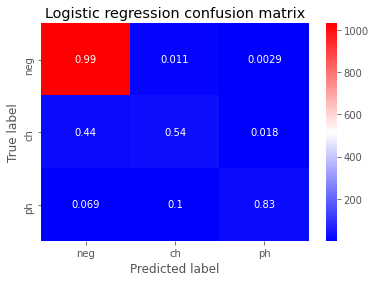

In [ ]:
conf_matrix(y_test, y_pred, target_names)

In [ ]:
gs.best_params_

{'estimator__n_neighbors': 5,
 'estimator__p': 2,
 'estimator__weights': 'uniform',
 'feature_selection__estimator__C': 0.05555555555555555}

In [ ]:
print(f1_score(y_train, y_pred_train, average='macro'))
print(f1_score(y_test, y_pred, average='macro'))

0.862110347363657
0.8101508140859267


KNN shows worse results than Logistic regression. Especially it badly predicts ch class: we can see low recall, precision, and f1 accordingly.

## Random Forest

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

pipeline = Pipeline([
    ('mapper', DataFrameMapper(features)),
    ('feature_selection', SelectFromModel(LinearSVC(C=0.17777, penalty="l1", dual=False, random_state=42, max_iter=10000))),
    ('estimator', RandomForestClassifier(random_state=42)),
    
])

grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth' : [1, 2, 3, 4, 6, 7, 8, 9, 10, 11],
    'estimator__criterion' :['gini', 'entropy'],

}

gs = GridSearchCV(pipeline, grid, 
                  n_jobs=-1, 
                  scoring=f1,
                  cv=cv,
                  verbose=5)

In [ ]:
gs.fit(X_train, y_train)
y_pred = gs.predict(X_test)
y_pred_train = gs.predict(X_train)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.2min finished


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1045
           1       0.97      1.00      0.98        57
           2       0.97      0.97      0.97        29

    accuracy                           1.00      1131
   macro avg       0.98      0.99      0.98      1131
weighted avg       1.00      1.00      1.00      1131



[[1043    1    1]
 [   0   57    0]
 [   0    1   28]]


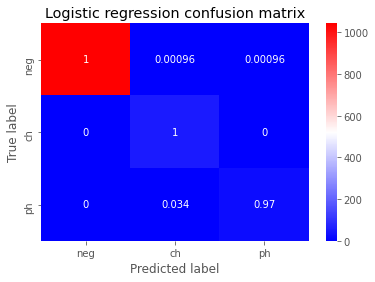

In [ ]:
conf_matrix(y_test, y_pred, target_names)

In [ ]:
gs.best_params_

{'estimator__criterion': 'gini',
 'estimator__max_depth': 9,
 'estimator__n_estimators': 200}

In [ ]:
print(f1_score(y_train, y_pred_train, average='macro'))
print(f1_score(y_test, y_pred, average='macro'))

0.9987194465699906
0.9824393358876118


It seems, that RandomForestClassifier is the best algorithm in our case (only 3 mistakes).

# Conclusion

In this work we:
* Conducted simple EDA and got some insights in data;
* Prepared features for classification (filled missing values, applied transformations);
* Built baseline model;
* Generated new samples to deal with imbalanced data (but both approaches didn't improve score significantly);
* Built pipelines with feature selection, transformations and different classifiers;
* Compared different classification algorithms, used cross validation and tried to search best parameters using GridSearch.

To sum up, the best score - RandomForestClassifier (f1 = 0.982), the second best score - LogisticRegression (f1 = 0.921).